# Visualizing Neural Network Learning
In this notebook we'll visualize the learning/training process of a neural network on a toy problem.

Specifically we'll build a synthetic dataset, sample from it, and try to build a neural network model that predicts data unseen during training. The dataset is intended to capture the relationship between **commute-duration** (i.e., travel time to work, dependent variable) given **time-of-departure** and **weather-condition** (independent variables).

Note that the latest version of this notebook is available from: [https://github.com/miroenev/teach_DL](https://github.com/miroenev/teach_DL). 

Lastly, a video walkthrough of this notebook is <a href='https://youtu.be/HgbGJn9yz30'> available on YouTube</a>.

# Installing Pre-requisites:
Prerequisites: Matplotlib, Numpy, Tensorflow [ 2.0.0-beta-1 ] + Keras, and K3D ( for 3D plotting) 

In [1]:
installTF2 = False
if installTF2:
    !pip install tensorflow==2.0.0-beta1

K3D is a plotting tool that allows for 3D visualization in the jupyter notebook.
<a href="https://github.com/K3D-tools/K3D-jupyter">K3D</a> 3D plotting
To install it change `installK3D = True`

In [2]:
installK3D = False
if installK3D:
    !chmod +x utils/install-k3d.sh; ./utils/install-k3d.sh

# Import libraries

In [3]:
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import k3d

#set default figure size
plt.rcParams['figure.figsize'] = [9.5, 5]

# Define the problem

Lets try to predict commute duration from two observable independent variables: the time of day and the weather conditions.

<img src='figures/commute.png' width='400'/>
<img src='figures/target_distribution.PNG' width='1000'/>
In this toy example we'll first take on the role of the 'traffic gods' and decree that commute duration is defined through a linear mixture of the two independent variables. Later we'll sample from the distribution defined by these variables and generate a training dataset. This sampling procedure will be analogous to keeping a journal of all of our commutes for some [ long ] period of time, where each log entry consists of a set of  
* <b>X</b>: [ time-of-departure, weather-condition ], and the associated  
* <b>Y</b>: [ commute-duration ].

<img src='figures/x_y_mapping.PNG' width='900'/>

Given such a journal [dataset], we'll split it into training (75%) and testing (25%) subsets which we'll use to train and evaulate our model respectively. Specifically, we'll build a neural network model whose weights are initially randomly initialized, but are trained/updated as we stream the training data through (via the backpropagation learning algorithm). Each update will get us closer to having a model that has learned the relationship between X and Y or ([ time-of-departure, weather-condition ] to [ commute-duration] ).

<img src='figures/process.PNG' width='800'/>

During the training process we'll try to visualize the network's behavior by asking it to predict all the entries in our logbook using its current parameters/weights. As the training process unfolds, you should be able to see how the network adapts itself to the target surface/function that we determined for the commute duration.

<img src='figures/training_progress.PNG' width='700'/>

# Determine underlying relationship
We'll start by esablishing (as traffic gods) the relationships between:  
* 1) the time a commute starts (time-of-departure variable) and commute-duration
* 2) the weather when a commute is started (weather-condtion variable) and commute-duration

Note that as data scientists we never get to see this function, but we try to learn it from data.

In [5]:
# define data coordinates
xRange = [0, 3*np.pi]; 
yRange = [0, 3*np.pi]; numSteps = 1000

x, y = np.meshgrid( np.linspace(xRange[0], xRange[1], numSteps),
                    np.linspace(yRange[0], yRange[1], numSteps), indexing='ij' )

def normalize_domain (x):
    x = x + np.abs(np.min(x))
    x = x / (np.max(x) + .001)
    return x

# define 1D relationships to target
xComponent = np.sin( x ) * 2
yComponent = np.exp( y / 5 )

# define 2D joint distribution
z = xComponent + yComponent
z = normalize_domain(z)

<IPython.core.display.Javascript object>


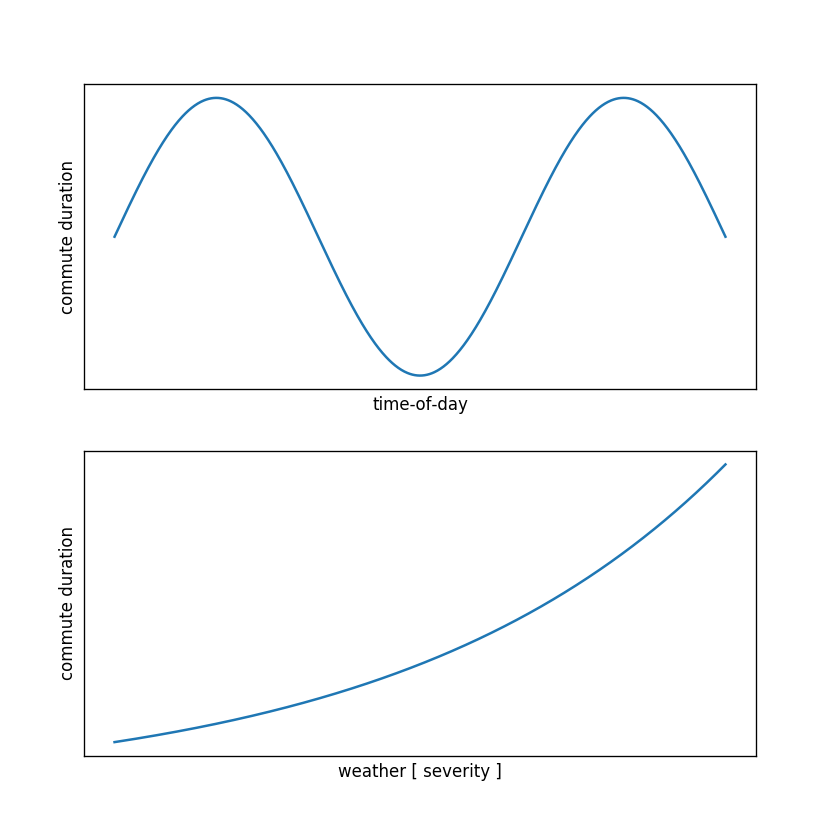

<IPython.core.display.Javascript object>


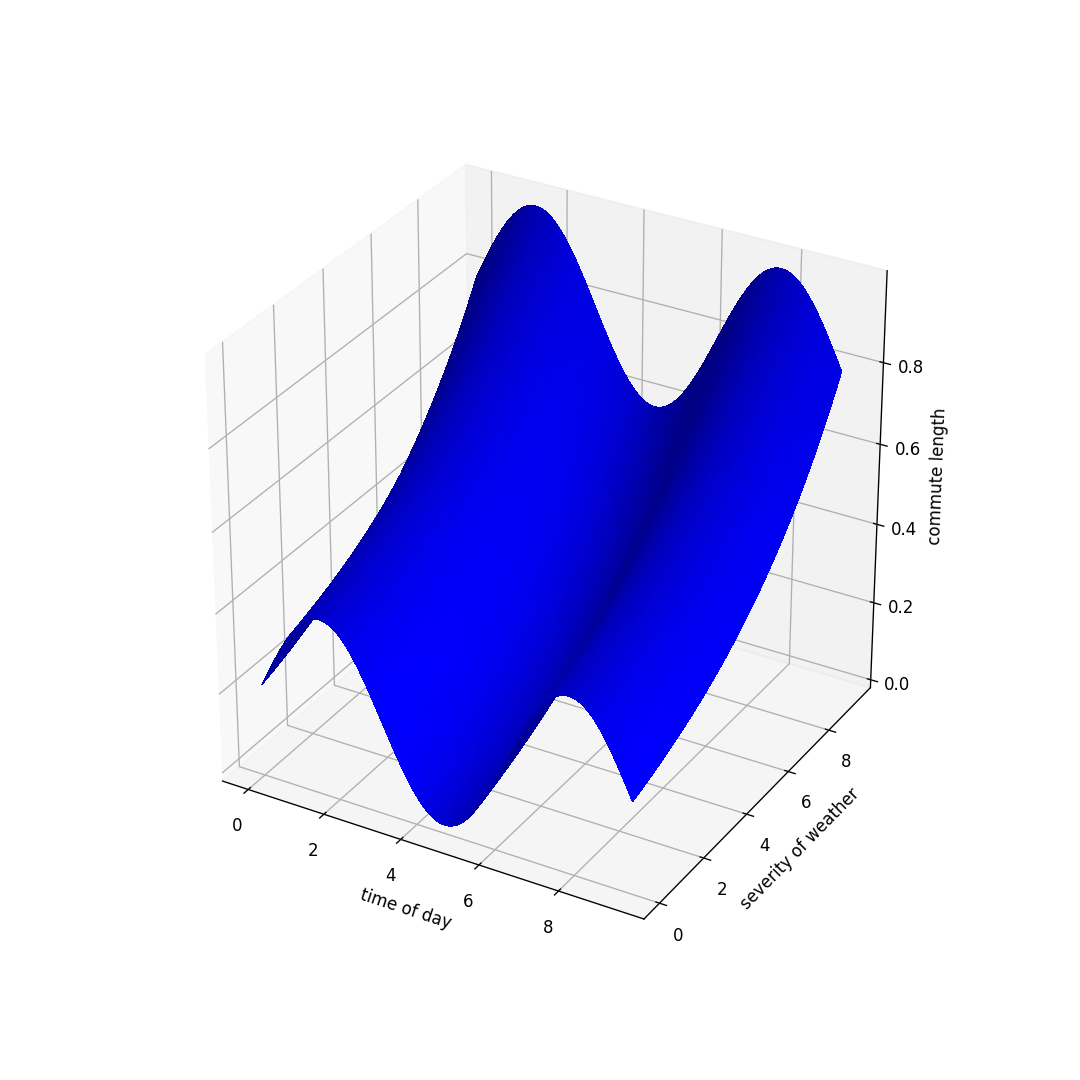

In [6]:
# plot independent variables
plt.figure( figsize = ( 7, 7) )
plt.subplots_adjust( left = 0.1, right = 0.9, top = 0.9, bottom = 0.1, wspace = 0.2 )
plt.subplot(2,1,1); plt.plot(normalize_domain(xComponent[:,0])); plt.xlabel('time-of-day'), plt.ylabel('commute duration')
plt.xticks([]), plt.yticks([])
plt.subplot(2,1,2); plt.plot(normalize_domain(yComponent[0,:])); plt.xlabel('weather [ severity ]'), plt.ylabel('commute duration')
plt.xticks([]), plt.yticks([])

# plot target [dependent] variable
plt.figure( figsize = (9, 9) )
plt.subplots_adjust( left = 0.1, right = 0.9, top = 0.9, bottom = 0.1 )
ax = plt.subplot(1,1,1, projection='3d');
ax.plot_surface ( x[0::1], y[0::1], z[0::1], color = 'blue', alpha = 1, antialiased = False )
ax.set_xlabel('time of day')
ax.set_ylabel('severity of weather')
ax.set_zlabel('commute length')
plt.show()

# Generate  dataset
Lets generate a dataset by randomly sampling from the target distribution [ with some noise ].

In [7]:
NSamples = 10000
noiseScaling = 1/8.

shuffledDataIndsX = np.random.randint(x.shape[0], size=(NSamples,1))
shuffledDataIndsY = np.random.randint(y.shape[0], size=(NSamples,1))

data = np.zeros( ( NSamples, 2 ) )
labels = np.zeros( (NSamples, 1 ))
noiseAmount = noiseScaling * ( np.random.rand(NSamples) - .5 )

for iSample in range (NSamples):
    data[iSample, 0] = x[ shuffledDataIndsX[iSample], 0 ]
    data[iSample, 1] = y[ 0, shuffledDataIndsY[iSample] ]    
    labels[iSample] = z[ shuffledDataIndsX[iSample], shuffledDataIndsY[iSample] ] + noiseAmount[iSample]


In [8]:
trainData, testData, trainLabels, testLabels = train_test_split(data, labels, test_size = .25)

# Plot dataset samples (red dots) overlayed onto target distribution (blue)

In [9]:
def plot_3D_data (k3dPlot):
    zScaling = 5

    offset = np.hstack( ( np.ones((trainData.shape[0], 1)) * -5, 
                          np.ones((trainData.shape[0], 1)) + 4, 
                          np.zeros((trainData.shape[0], 1)) ) ) * np.abs(xRange[1]-xRange[0])

    k3dPlot += k3d.points ( np.hstack( ( trainData, trainLabels*zScaling) ) + offset, color=0xFF0000, point_size = .1, shader = 'flat' )
    k3dPlot += k3d.surface ( np.rot90(z,-1)*zScaling, color=0x0055FF, xmin=np.min(trainData[:,0]+offset[::,0]), xmax=np.max(trainData[:,0]+offset[::,0]), ymin=np.min(trainData[:,1]+offset[::,1]), ymax=np.max(trainData[:,1]+offset[::,1]))
    
    return zScaling, offset

plot = k3d.plot()
_, _ = plot_3D_data(plot)
plot.display()

Output()

# Define model structure

In [10]:
import tensorflow as tf

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import metrics

In [12]:
model = Sequential()
model.add( Dense( 10, input_dim = 2 ))
model.add( Dense( 10, activation = 'sigmoid' ))
model.add( Dense( 13, activation = 'sigmoid' ))
model.add( Dense( 42, activation = 'sigmoid' ))
model.add( Dense( 1 ))

In [13]:
model.compile(optimizer='adam', loss='mse')

# Visualize network structure

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                30        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 13)                143       
_________________________________________________________________
dense_3 (Dense)              (None, 42)                588       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 43        
Total params: 914
Trainable params: 914
Non-trainable params: 0
_________________________________________________________________


In [15]:
import matplotlib.pylab as plt

In [16]:
import sys
sys.path.append('utils')
import nnViz
import importlib

<IPython.core.display.Javascript object>


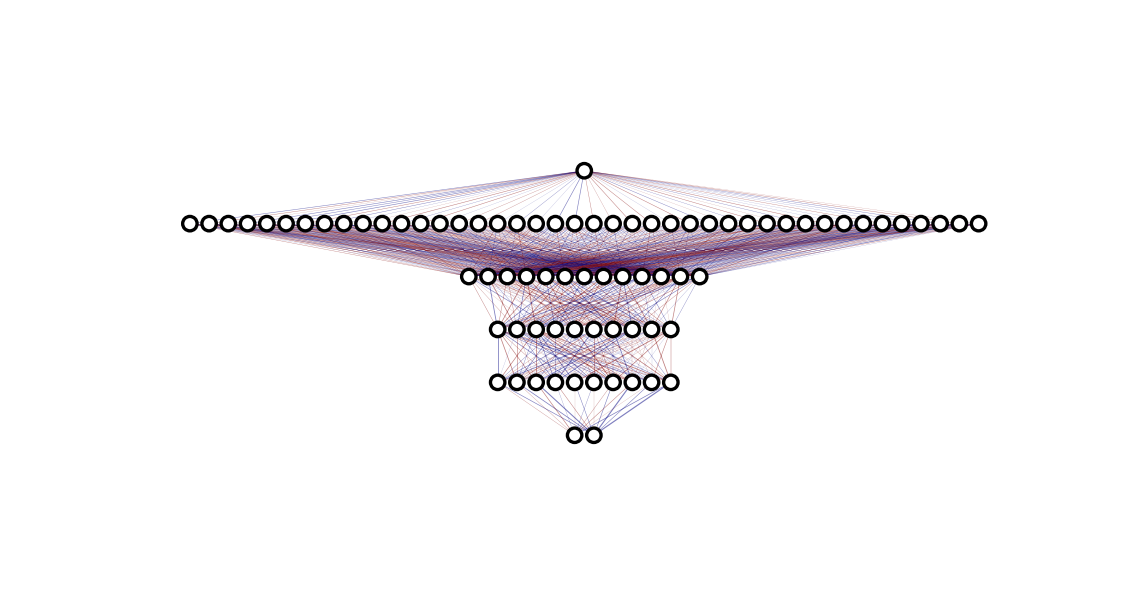

In [17]:
importlib.reload(nnViz)
model.compile(optimizer = 'adam', loss='mse')

plt.figure()
nnViz.visualize_model(model)
untrainedModelCopy = tf.keras.models.clone_model(model)

Note that the weights all have a similar width/thickness as they are initialized from the same random distribution.

# Train Network (and dynamically visualize)

In [18]:
batchSize = 128
numberEpochsToTrain = 300
displayUpdateInterval = 10

In [19]:
currentNN = {}

''' offsets need to keep track of where to plot the latest model predictions '''
xOffset = np.zeros( (trainData.shape[0], 1))
yOffset = np.zeros( (trainData.shape[0], 1))
zOffset = np.zeros( (trainData.shape[0], 1))

xModifier = 1 * np.abs(xRange[1]-xRange[0])*1.2; yModifier = 0; zModifier = 0; 
plotCount = 0

# placeholders to store loss history
trainLoss = np.empty((numberEpochsToTrain))
testLoss = np.empty((numberEpochsToTrain))
trainLoss[:] = np.NaN
testLoss[:] = np.NaN

# 3D plot
plot = k3d.plot()
zScaling, offset = plot_3D_data(plot)
plot.display()

''' training & plotting loop '''
for iEpoch in range( numberEpochsToTrain ):
    
    # update model parameters
    model.fit ( trainData, trainLabels, 
               epochs = 1, 
               batch_size = batchSize,
               verbose = 0, 
               shuffle = True )
     
    # store loss/error history
    trainLoss[iEpoch] = model.evaluate( trainData, trainLabels )
    testLoss[iEpoch] = model.evaluate( testData, testLabels)
    
    # plot logic
    if iEpoch % displayUpdateInterval == 0:
        comboOffset = np.hstack( (xOffset + xModifier, yOffset + yModifier, zOffset + zModifier) )
        
        currentNN[plotCount] = model.predict( trainData )
        
        print('\n train error: {}, test error: {}'.format( trainLoss[plotCount], testLoss[plotCount])  )
        plot += k3d.points ( np.hstack( ( trainData, currentNN[plotCount] * zScaling) ) + comboOffset + offset, color=0xA9A9FF, point_size = .2, shader = 'flat' )        
        #plot += k3d.text2d ( str( round(evalLoss[plotCount], 4 )), comboOffset + offset + (0, 0, 3), color=0xff00ff, size=.5, reference_point='rb')
        
        plotCount += 1
        if plotCount % 8 == 0:
            xModifier = 1 * np.abs(xRange[1]-xRange[0])*1.2
            yModifier -= 1 * np.abs(yRange[1]-yRange[0])*1.2
        else:
            xModifier += 1 * np.abs(xRange[1]-xRange[0])*1.2

Output()

2500/2500 [==============================] - 0s 23us/sample - loss: 0.0411

 train error: 0.040767538913091025, test error: 0.041066721034049986
2500/2500 [==============================] - 0s 17us/sample - loss: 0.0219

 train error: 0.03513619143168131, test error: 0.03549056761860848
2500/2500 [==============================] - 0s 16us/sample - loss: 0.0188

 train error: 0.030583153369029364, test error: 0.031043696039915084
2500/2500 [==============================] - 0s 16us/sample - loss: 0.0116

 train error: 0.02823657192985217, test error: 0.028700794541835786
2500/2500 [==============================] - 0s 17us/sample - loss: 0.0045

 train error: 0.02644369079867999, test error: 0.026888752007484435
2500/2500 [==============================] - 0s 16us/sample - loss: 0.0035

 train error: 0.02441234011054039, test error: 0.02484249672293663
2500/2500 [==============================] - 0s 17us/sample - loss: 0.0032

 train error: 0.022984413081407546, test error: 0.0234020771

# Plot learning curve

<IPython.core.display.Javascript object>


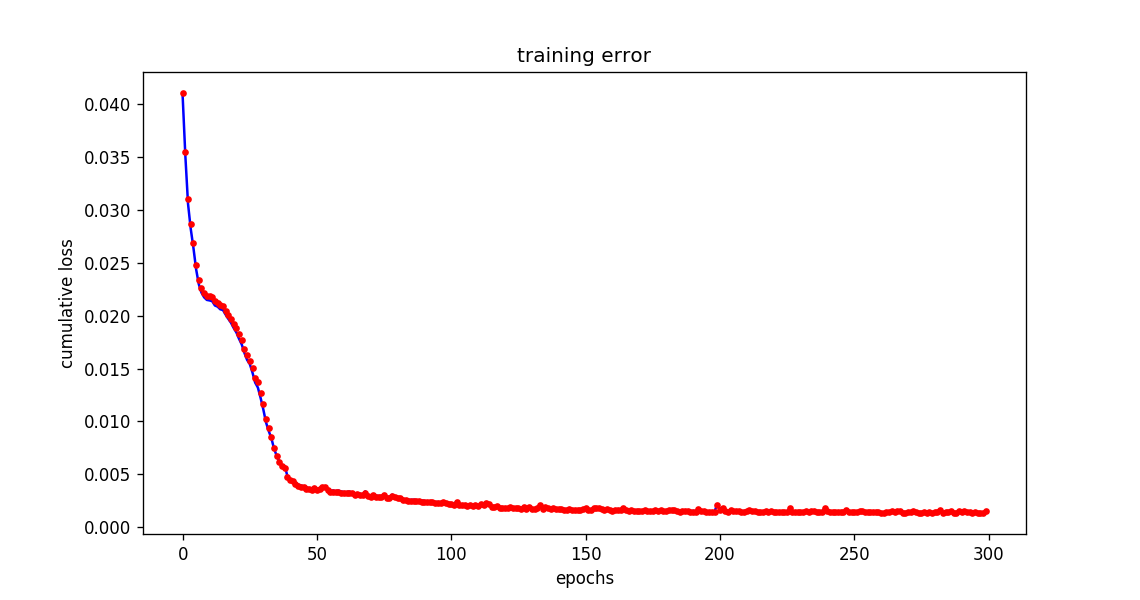

Text(0, 0.5, 'cumulative loss')

In [20]:
plt.figure()
plt.plot(trainLoss[:], 'b')
plt.plot(testLoss[:], 'or', markersize=3)
plt.title('training error')
plt.xlabel('epochs')
plt.ylabel('cumulative loss')

# Visualize network predictions <font color=FF0000>before</font> any training

In [21]:
plot = k3d.plot()
plot += k3d.points ( np.hstack( ( trainData, currentNN[0]*zScaling) ), color=0xFF00FF, point_size = .3, shader = 'flat' )        
plot += k3d.surface ( np.rot90(z,-1) * zScaling, color=0x888888, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

Output()

# Visualize network predictions <font color=FF0000>midway</font> through training

In [22]:
plot = k3d.plot()

plot += k3d.points ( np.hstack( ( trainData, currentNN[int(plotCount/2)]*zScaling) ), color=0xFF00FF, point_size = .3, shader = 'flat' )        
plot += k3d.surface ( np.rot90(z, -1) * zScaling, color=0x555555, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

Output()

# Visualize network predictions at <font color=FF0000>end</font> of training

In [23]:
plot = k3d.plot()
plot += k3d.points ( np.hstack( ( trainData, currentNN[plotCount-1]*zScaling) ), color=0xFF00FF, point_size = .3, shader = 'flat' )        
plot += k3d.surface ( np.rot90(z, -1) * zScaling, color=0x555555, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

Output()

# Visualize weights before and after training

<IPython.core.display.Javascript object>


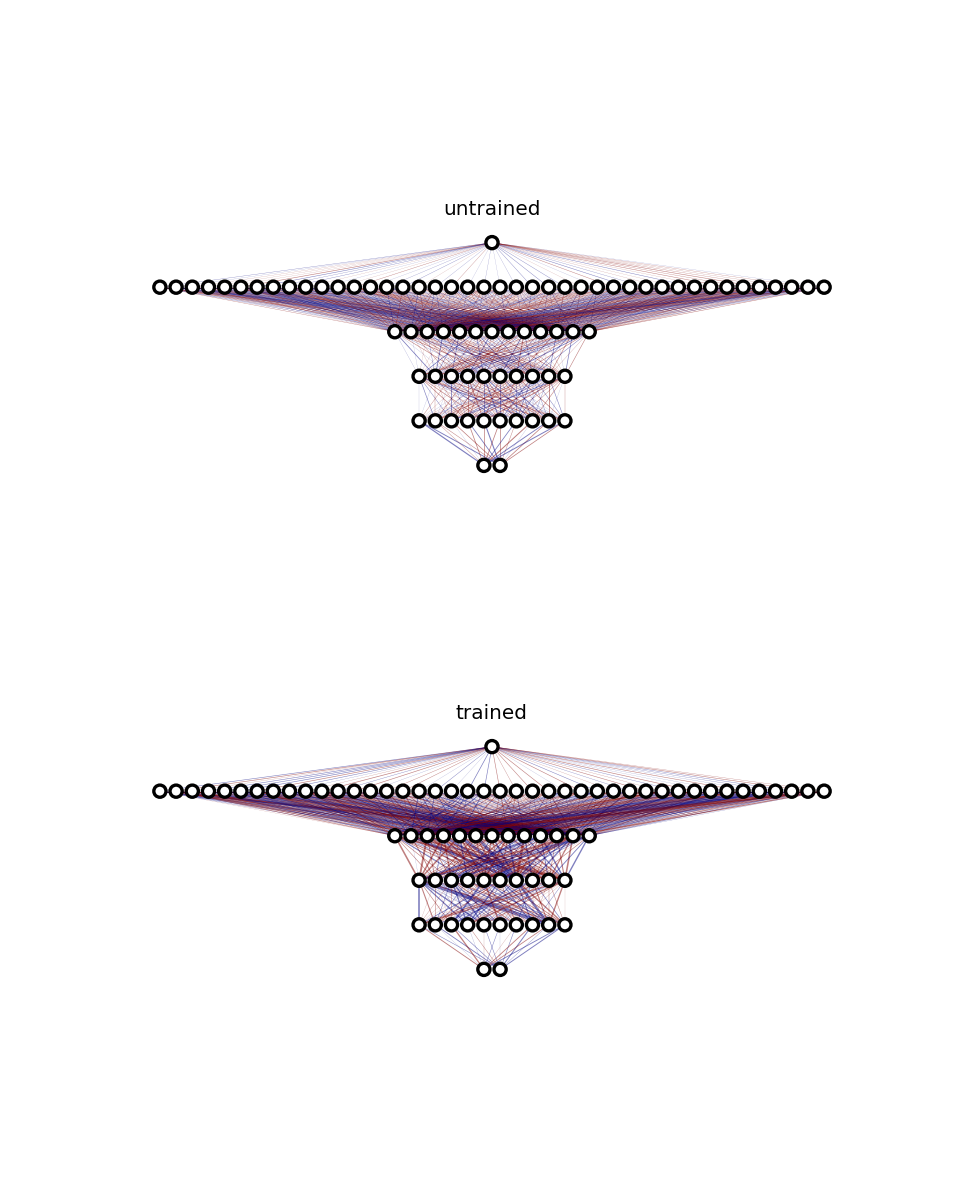

In [24]:
importlib.reload(nnViz)

plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
nnViz.visualize_model(untrainedModelCopy)
plt.title('untrained');

plt.subplot(2,1,2)
plt.title('trained');
nnViz.visualize_model(model)

In [25]:
print('thanks!')

thanks!
